In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import keras
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import seaborn as sns
from numpy import array
from numpy import hstack
from sklearn.metrics import mean_squared_error, explained_variance_score
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras import layers
from keras import Input
import keras
import math
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 다변량
def split_mult_data(data, timestep, lag):
    x, y = [], []
    for i in range(len(data)):
        end_ix = i + timestep
        out_end_ix = end_ix + lag
        if out_end_ix > len(data):
            break;
        seq_x, seq_y = data[i:end_ix, :], data[end_ix:out_end_ix, 0]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

# 단일
def split_data(data, timestep):
    x, y = [], []
    for i in range(len(data)):
        end_ix = i + timestep
        if end_ix > len(data)-1:
            break
        seq_x, seq_y = data[i:end_ix], data[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

# 데이터 분할 함수 : 6.2.2
def split(data_x, data_y):
    train_size = int(len(data_x)*0.6)
    val_size = int(len(data_x)*0.8)
    
    data_train_x = data_x[:train_size]
    data_val_x = data_x[train_size:val_size]
    data_test_x = data_x[val_size:]
    
    data_train_y = data_y[:train_size]
    data_val_y = data_y[train_size:val_size]
    data_test_y = data_y[val_size:] 
    
    return data_train_x, data_val_x, data_test_x, data_train_y, data_val_y, data_test_y

def normalization(data_train, data_val, data_test):
    scaler = MinMaxScaler() #StandardScaler
    scaler.fit(data_train)
    n_data_train = scaler.transform(data_train)
    n_data_val = scaler.transform(data_val)
    n_data_test = scaler.transform(data_test)
    return n_data_train, n_data_val, n_data_test

# 뉴스 데이터

In [2]:
# 뉴스 데이터 
news = pd.read_csv('사회적거리두기 뉴스.csv')
# news.drop(['Unnamed: 0'], axis='columns', inplace=True)
news

,날짜,뉴스 수
0,2020-01-20,0
1,2020-01-21,0
2,2020-01-22,0
3,2020-01-23,0
4,2020-01-24,0
...,...,...
430,2021-03-25,1
431,2021-03-26,17
432,2021-03-27,3
433,2021-03-28,13


# 검색어 데이터

In [3]:
# 코로나 관련 검색어
search_covid19 = pd.read_csv("5인이상_검색어.csv")
search_covid19

,날짜,5인이상
0,2020-01-20,0.00000
1,2020-01-21,0.00000
2,2020-01-22,0.00000
3,2020-01-23,0.00000
4,2020-01-24,0.00000
...,...,...
430,2021-03-25,5.46614
431,2021-03-26,7.22695
432,2021-03-27,4.22074
433,2021-03-28,3.72146


# 코로나 데이터

In [5]:
# 코로나 데이터
covid19 = pd.read_csv("covid19.csv",  header=0, squeeze=True)
covid19 = covid19[{'decide_per_day' : '확진자', 'recovered_per_day' : '완치자'}]
covid19.columns = ['확진자', '완치자']
covid19

,확진자,완치자
0,1,0
1,0,0
2,0,0
3,0,0
4,1,0
...,...,...
430,494,562
431,505,845
432,482,420
433,384,269


In [6]:
# 인구이동 _ 저장한 csv 불러오기
local_people_df = pd.read_csv('seoul_people.csv')
local_people_df.columns = ['날짜', '인구이동']

local_people_df

,날짜,인구이동
0,2020-01-20,263707987
1,2020-01-21,263999557
2,2020-01-22,263092698
3,2020-01-23,255740975
4,2020-01-24,230503552
...,...,...
430,2021-03-25,253723156
431,2021-03-26,253132397
432,2021-03-27,245764635
433,2021-03-28,244437877


# 총 데이터 시각화

<AxesSubplot:>

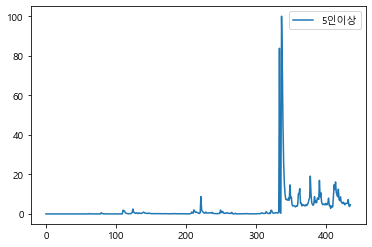

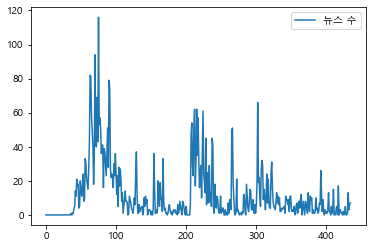

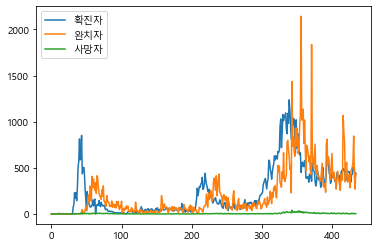

In [17]:
search_covid19.plot()

news.plot()

covid19.plot()

# 6:2:2 

In [43]:
timestep = 1
lag = 1

news_data = news['뉴스 수'].values

news_x, news_y = split_data(news_data, timestep)

for i in range(40,50):
    print('news_x : ',news_x[i], 'news_y : ', news_y[i])
    
print('뉴스 : ', news_x.shape)

news_train_x, news_val_x, news_test_x, news_train_y, news_val_y, news_test_y = split(news_x, news_y)
print(len(news_train_x), len(news_val_x), len(news_test_x), len(news_train_y), len(news_val_x), len(news_test_y), news_train_x.shape)
#----------------------------------------------------------
search_data = search_covid19['5인이상'].values

search_x, search_y = split_data(search_data, timestep)

for i in range(10):
    print('search_x : ',search_x[i], 'search_y : ', search_y[i])
    
print('네이버 검색어 전 : ', search_x.shape)

## LSTM 경우 ###
# reshape from [samples, timesteps] into [samples, timesteps, features]
search_features = 1
search_x = search_x.reshape((search_x.shape[0], search_x.shape[1], search_features))
print('네이버 검색어 후 : ', search_x.shape)

search_train_x, search_val_x, search_test_x, search_train_y, search_val_y, search_test_y = split(search_x, search_y)
print(len(search_train_x), len(search_val_x), len(search_test_x), len(search_train_y), len(search_val_x), len(search_test_y), search_train_x.shape)
#-----------------------------------------------------------
covid19_data = covid19.values

covid_x, covid_y = split_mult_data(covid19_data, timestep, lag)

for i in range(40,50):
    print('covid_x : ',covid_x[i], 'covid_y : ', covid_y[i])

print('코로나 : ', covid_x.shape)

covid_train_x, covid_val_x, covid_test_x, covid_train_y, covid_val_y, covid_test_y = split(covid_x, covid_y)
print(len(covid_train_x), len(covid_val_x), len(covid_test_x), len(covid_train_y), len(covid_val_x), len(covid_test_y), covid_train_x.shape)
#--------------------------------------------------------------
# people_data = local_people_df['총 인구 이동'].values

# people_x, people_y = split_data(people_data, timestep)

# for i in range(40,50):
#     print('people_x : ',people_x[i], 'people_y : ', people_y[i])
    
# print('총 인구 이동 : ', people_x.shape)

# people_train_x, people_val_x, people_test_x, people_train_y, people_val_y, people_test_y = split(people_x, people_y)
# print(len(people_train_x), len(people_val_x), len(people_test_x), len(people_train_y), len(people_val_x), len(people_test_y), people_train_x.shape)

news_x :  [4] news_y :  5
news_x :  [5] news_y :  14
news_x :  [14] news_y :  11
news_x :  [11] news_y :  21
news_x :  [21] news_y :  17
news_x :  [17] news_y :  18
news_x :  [18] news_y :  4
news_x :  [4] news_y :  5
news_x :  [5] news_y :  20
news_x :  [20] news_y :  15
뉴스 :  (434, 1)
260 87 87 260 87 87 (260, 1)
search_x :  [0.] search_y :  0.0
search_x :  [0.] search_y :  0.0
search_x :  [0.] search_y :  0.0
search_x :  [0.] search_y :  0.0
search_x :  [0.] search_y :  0.0
search_x :  [0.] search_y :  0.0
search_x :  [0.] search_y :  0.0
search_x :  [0.] search_y :  0.0035
search_x :  [0.0035] search_y :  0.0
search_x :  [0.] search_y :  0.0035
네이버 검색어 전 :  (434, 1)
네이버 검색어 후 :  (434, 1, 1)
260 87 87 260 87 87 (260, 1, 1)
covid_x :  [[813   2   3]] covid_y :  [586]
covid_x :  [[586   1   1]] covid_y :  [599]
covid_x :  [[599   3  11]] covid_y :  [851]
covid_x :  [[851   7   0]] covid_y :  [435]
covid_x :  [[435  47   7]] covid_y :  [467]
covid_x :  [[467  20   0]] covid_y :  [505]


# Train / Test 분할
- 뉴스 데이터

In [26]:
news_train_x, news_val_x, news_test_x, news_train_y, news_val_y, news_test_y = split(news_x, news_y)
len(news_train_x), len(news_val_x), len(news_test_x), len(news_train_y), len(news_val_x), len(news_test_y), news_train_x.shape

(252, 84, 85, 252, 84, 85, (252, 14))

- 검색어 데이터

In [27]:
search_train_x, search_val_x, search_test_x, search_train_y, search_val_y, search_test_y = split(search_x, search_y)
len(search_train_x), len(search_val_x), len(search_test_x), len(search_train_y), len(search_val_x), len(search_test_y), search_train_x.shape

(252, 84, 85, 252, 84, 85, (252, 14, 1))

- 코로나 데이터

In [28]:
covid_train_x, covid_val_x, covid_test_x, covid_train_y, covid_val_y, covid_test_y = split(covid_x, covid_y)
len(covid_train_x), len(covid_val_x), len(covid_test_x), len(covid_train_y), len(covid_val_x), len(covid_test_y)

(252, 84, 85, 252, 84, 85)

- 인구 데이터

# 뉴스 / 코로나 데이터 정규화
- 검색어 데이터는 이미 되어있으므로 생략

In [29]:
# ######## time_step : 1일 때 ##########
# # 코로나가 3차원이므로 2차원으로 바꿔준다 - 정규화를 위해서!
# n_covid_train_x = covid_train_x.reshape(covid_train_x.shape[0], covid_train_x.shape[2])
# n_covid_val_x = covid_val_x.reshape(covid_val_x.shape[0], covid_val_x.shape[2])
# n_covid_test_x = covid_test_x.reshape(covid_test_x.shape[0], covid_test_x.shape[2])

# n_covid_train_x.shape

In [30]:
######## time_step 2이상 일 때 #########
n_covid_train_x = covid_train_x.reshape(covid_train_x.shape[0], covid_train_x.shape[1]*covid_train_x.shape[2])

n_covid_val_x = covid_val_x.reshape(covid_val_x.shape[0], covid_train_x.shape[1]*covid_val_x.shape[2])
n_covid_test_x = covid_test_x.reshape(covid_test_x.shape[0], covid_train_x.shape[1]*covid_test_x.shape[2])

n_covid_train_x.shape

(252, 42)

In [33]:
# 데이터 정규화
covid_train_x, covid_val_x, covid_test_x = normalization(n_covid_train_x, n_covid_val_x, n_covid_test_x)
news_train_x, news_val_x, news_test_x = normalization(news_train_x, news_val_x, news_test_x)

In [34]:
# 형태 복원 - 코로나 데이터
covid_train_x = covid_train_x.reshape(covid_train_x.shape[0], covid_x.shape[1], covid_x.shape[2])
covid_val_x = covid_val_x.reshape(covid_val_x.shape[0], covid_x.shape[1], covid_x.shape[2])
covid_test_x = covid_test_x.reshape(covid_test_x.shape[0], covid_x.shape[1], covid_x.shape[2])

covid_train_x.shape

(252, 14, 3)

In [35]:
# 형태 변형시켜줌 - 뉴스 데이터
news_features = 1
news_train_x = news_train_x.reshape((news_train_x.shape[0], news_train_x.shape[1], news_features))
news_val_x = news_val_x.reshape((news_val_x.shape[0], news_val_x.shape[1], news_features))
news_test_x = news_test_x.reshape((news_test_x.shape[0], news_test_x.shape[1], news_features))

news_train_x.shape

(252, 14, 1)

# 모델 생성
- 함수형 API

In [39]:
from keras.models import Model
from keras import layers
from keras import Input
import keras
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, explained_variance_score
import tensorflow as tf

tf.random.set_seed(55)

input_news = Input(shape=(timestep, news_features))
lstm_n1 = layers.LSTM(32, return_sequences=True)(input_news) # 뉴스
lstm_n2 = layers.LSTM(16, activation='relu', return_sequences= False)(lstm_n1)
# 잔차 연결
lgraph = layers.add([lstm_n2, lstm_n1])

input_search = Input(shape=(timestep, search_features))
lstm_s1 = layers.LSTM(32, return_sequences=True)(input_search) # 검색어
lstm_s2 = layers.LSTM(16, activation='relu', return_sequences= False)(lstm_s1)

input_covid = Input(shape=(timestep, covid_features)) # 코로나
lstm_c1 = layers.LSTM(32, return_sequences=True)(input_covid)
lstm_c2 = layers.LSTM(16, activation='relu', return_sequences= False)(lstm_c1)

# 연결
concatenated = layers.concatenate([lstm_n2, lstm_s2, lstm_c2]) ####

result = layers.Dense(lag)(concatenated)

model = Model([input_news, input_search, input_covid], result) ####
model.compile(optimizer='adam', loss=['mse'], metrics=['mae'])

callback_list = [
  keras.callbacks.EarlyStopping(
    monitor='val_loss', # 모델의 검증 정확도 모니터링
    patience=20, # 1 에포크보다 더 길게 향상되지 않으면 중단
  ),
  keras.callbacks.ModelCheckpoint(
    filepath='my_model.h5', # 저장
    monitor='val_loss',
    save_best_only=True, # 가장 좋은 모델
  )
]
# batch_size : batch_size만큼 보고 가중치를 업데이트 주겠다
hist = model.fit([news_train_x, search_train_x, covid_train_x], covid_train_y, epochs=1000, batch_size=5, callbacks=callback_list, validation_data=([news_val_x, search_val_x, covid_val_x], covid_val_y)) ####

Epoch 1/1000
51/51 [==============================] - 3s 65ms/step - loss: 23174.4883 - mae: 92.0207 - val_loss: 262141.2188 - val_mae: 375.0168
Epoch 2/1000
51/51 [==============================] - 2s 47ms/step - loss: 17324.2617 - mae: 80.2083 - val_loss: 236060.5312 - val_mae: 351.0819
Epoch 3/1000
51/51 [==============================] - 2s 46ms/step - loss: 17137.9570 - mae: 84.3966 - val_loss: 257620.4219 - val_mae: 371.9485
Epoch 4/1000
51/51 [==============================] - 2s 46ms/step - loss: 16428.8145 - mae: 78.5068 - val_loss: 259097.8281 - val_mae: 369.9281
Epoch 5/1000
51/51 [==============================] - 2s 45ms/step - loss: 15004.9111 - mae: 78.1924 - val_loss: 279428.3125 - val_mae: 391.1437
Epoch 6/1000
51/51 [==============================] - 2s 45ms/step - loss: 15600.7832 - mae: 78.4024 - val_loss: 276778.4688 - val_mae: 383.8479
Epoch 7/1000
51/51 [==============================] - 2s 45ms/step - loss: 14721.8828 - mae: 75.0963 - val_loss: 273956.0312 - val

KeyboardInterrupt: 

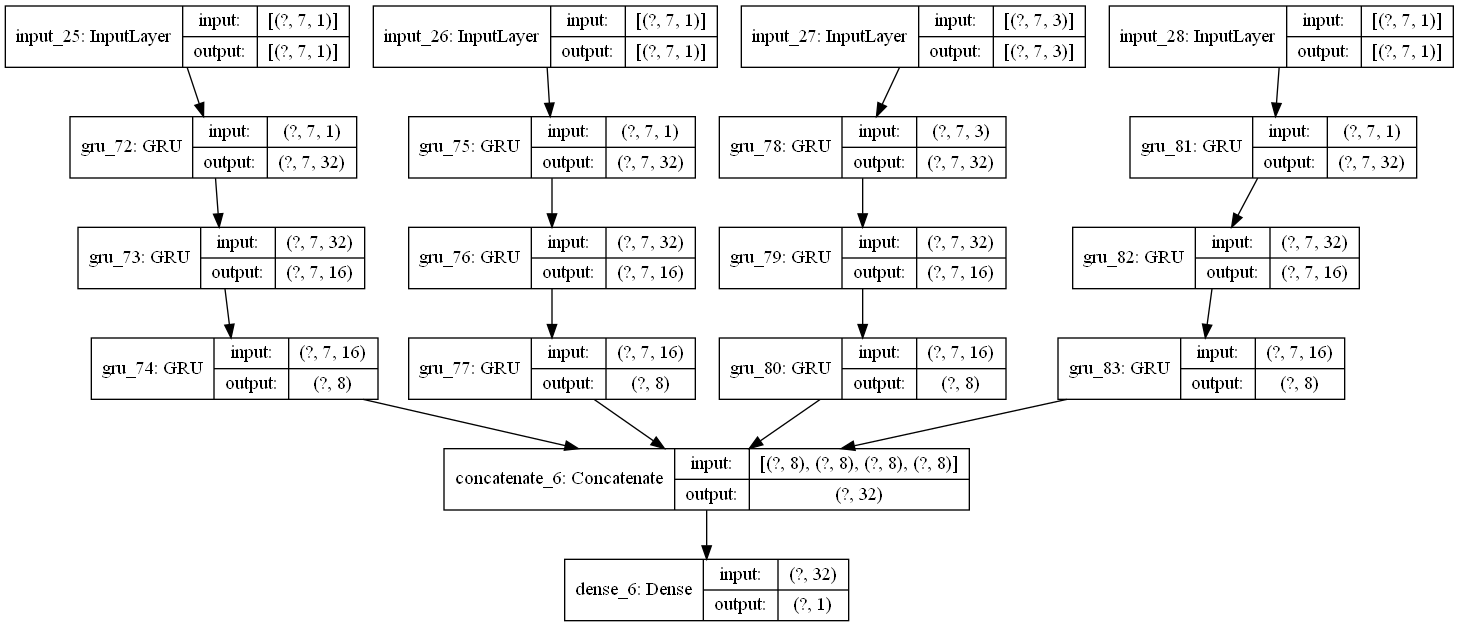

In [11]:
from keras.utils import plot_model
plot_model(model, to_file='model_20210124.png', show_shapes=True)

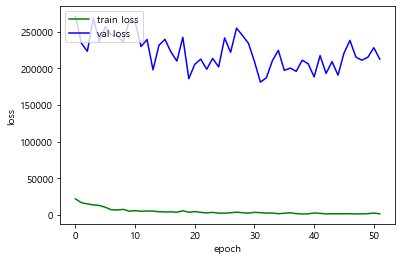

RMSE:  322.3
R-Square:  0.02


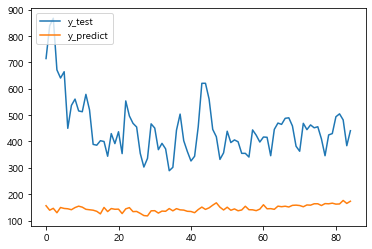

    y_test   y_predict
0      715  156.200974
1      839  139.114395
2      868  146.283875
3      672  129.497253
4      641  149.398849
..     ...         ...
80     494  162.197189
81     505  162.825882
82     482  176.139633
83     384  164.886490
84     441  173.167862

[85 rows x 2 columns]


In [72]:
# 학습 시각화 함수
def learning_graph(hist):
    fig, loss_ax = plt.subplots()
    loss_ax.plot(hist.history['loss'],'g', label='train loss')
    loss_ax.plot(hist.history['val_loss'],'b', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')
    plt.show()
    
learning_graph(hist)

# 실제값, 예측값 그래프
y_predict = model.predict([people_test_x, news_test_x, search_test_x, covid_test_x]) ####
# y_predict = model.predict([news_test_x, search_test_x, covid_test_x])

# 에러율 - Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_predict, covid_test_y))
print('RMSE: ',rmse.round(2))

r = explained_variance_score(covid_test_y, y_predict)
print('R-Square: ',r.round(2))

fig, loss_ax = plt.subplots()
loss_ax.plot(covid_test_y, label='y_test')
loss_ax.plot(y_predict, label='y_predict')
loss_ax.legend(loc='upper left')
plt.show()

df = pd.DataFrame(covid_test_y)
df.insert(1,'y_predict',y_predict)
df.rename(columns={0:'y_test'}, inplace=True)
print(df)

# 반복문으로 1~7까지 반복

In [7]:
lag = 1
news_data = news['뉴스 수'].values
search_data = search_covid19['5인이상'].values
covid19_data = covid19.values
people_data = local_people_df['인구이동'].values
rmse =[]
r2 = []

for timestep in range(1, 8, 1): 
    news_x, news_y = split_data(news_data, timestep)

    news_train_x, news_val_x, news_test_x, news_train_y, news_val_y, news_test_y = split(news_x, news_y)
    #----------------------------------------------------------
    search_x, search_y = split_data(search_data, timestep)
    ## LSTM 경우 ###
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    search_features = 1
    search_x = search_x.reshape((search_x.shape[0], search_x.shape[1], search_features))
    print('네이버 검색어 후 : ', search_x.shape)
    search_train_x, search_val_x, search_test_x, search_train_y, search_val_y, search_test_y = split(search_x, search_y)
    #-----------------------------------------------------------
    covid_x, covid_y = split_mult_data(covid19_data, timestep, lag)

    covid_train_x, covid_val_x, covid_test_x, covid_train_y, covid_val_y, covid_test_y = split(covid_x, covid_y)
    #--------------------------------------------------------------
    people_x, people_y = split_data(people_data, timestep)

    people_train_x, people_val_x, people_test_x, people_train_y, people_val_y, people_test_y = split(people_x, people_y)
    
    # 정규화
    n_covid_train_x = covid_train_x.reshape(covid_train_x.shape[0], covid_train_x.shape[1]*covid_train_x.shape[2])
    n_covid_val_x = covid_val_x.reshape(covid_val_x.shape[0], covid_train_x.shape[1]*covid_val_x.shape[2])
    n_covid_test_x = covid_test_x.reshape(covid_test_x.shape[0], covid_train_x.shape[1]*covid_test_x.shape[2])

    # 데이터 정규화
    covid_train_x, covid_val_x, covid_test_x = normalization(n_covid_train_x, n_covid_val_x, n_covid_test_x)
    news_train_x, news_val_x, news_test_x = normalization(news_train_x, news_val_x, news_test_x)
    people_train_x, people_val_x, people_test_x = normalization(people_train_x, people_val_x, people_test_x)

    print('코로나 데이터 형태 : ' ,covid_train_x.shape)
    print('뉴스 데이터 형태 : ' ,news_train_x.shape)
    print('검색어 데이터 형태 : ' ,search_train_x.shape)
    print('인구 이동 데이터 형태 : ' ,people_train_x.shape)
    
    ## LSTM = 1d CNN ###
    # 형태 복원(LSTM에 맞게) - 코로나 데이터
    covid_train_x = covid_train_x.reshape(covid_train_x.shape[0], covid_x.shape[1], covid_x.shape[2])
    covid_val_x = covid_val_x.reshape(covid_val_x.shape[0], covid_x.shape[1], covid_x.shape[2])
    covid_test_x = covid_test_x.reshape(covid_test_x.shape[0], covid_x.shape[1], covid_x.shape[2])

    print('코로나 데이터 형태 변환한거 원상복귀 : ', covid_train_x.shape)

    # 형태 변형시켜줌(1d CNN에 맞게) - 뉴스 데이터
    news_features = 1
    news_train_x = news_train_x.reshape((news_train_x.shape[0], news_train_x.shape[1], news_features))
    news_val_x = news_val_x.reshape((news_val_x.shape[0], news_val_x.shape[1], news_features))
    news_test_x = news_test_x.reshape((news_test_x.shape[0], news_test_x.shape[1], news_features))

    print('뉴스 데이터 형태 변환 : ' ,news_train_x.shape)

    # 형태 변형시켜줌(1d CNN에 맞게) - 인구 데이터
    people_features = 1
    people_train_x = people_train_x.reshape((people_train_x.shape[0], people_train_x.shape[1], people_features))
    people_val_x = people_val_x.reshape((people_val_x.shape[0], people_val_x.shape[1], people_features))
    people_test_x = people_test_x.reshape((people_test_x.shape[0], people_test_x.shape[1], people_features))

    print('인구 데이터 형태 변환 : ', people_train_x.shape)

    tf.random.set_seed(555)

    # Input
    input_news = Input(shape=(news_train_x.shape[1],news_train_x.shape[2]))
    lstm_n1 = layers.GRU(32, return_sequences=True)(input_news) # 뉴스
    lstm_n2 = layers.GRU(16, activation='relu', return_sequences= True)(lstm_n1)
    lstm_n3 = layers.GRU(8, activation='relu', return_sequences= False)(lstm_n2)

    input_search = Input(shape=(search_train_x.shape[1],search_train_x.shape[2]))
    lstm_s1 = layers.GRU(32, return_sequences=True)(input_search) # 검색어
    lstm_s2 = layers.GRU(16, activation='relu', return_sequences= True)(lstm_s1)
    lstm_s3 = layers.GRU(8, activation='relu', return_sequences= False)(lstm_s2)

    input_covid = Input(shape=(covid_train_x.shape[1],covid_train_x.shape[2])) # 코로나
    lstm_c1 = layers.GRU(32, return_sequences=True)(input_covid)
    lstm_c2 = layers.GRU(16, activation='relu', return_sequences= True)(lstm_c1)
    lstm_c3 = layers.GRU(8, activation='relu', return_sequences= False)(lstm_c2)

    input_people = Input(shape=(people_train_x.shape[1],people_train_x.shape[2]), dtype='float32')
    lstm_p1 = layers.GRU(32, return_sequences=True)(input_people)
    lstm_p2 = layers.GRU(16, activation='relu', return_sequences= True)(lstm_p1)
    lstm_p3 = layers.GRU(8, activation='relu', return_sequences= False)(lstm_p2)

    # 연결
    concatenated = layers.concatenate([lstm_n3, lstm_s3, lstm_c3, lstm_p3]) ####
    # Output
    result = layers.Dense(lag)(concatenated)

    model = Model([ input_covid, input_news, input_search, input_people], result) ####
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    callback_list = [
      keras.callbacks.EarlyStopping(
        monitor='val_loss', # 모델의 검증 정확도 모니터링
        patience=20, # 1 에포크보다 더 길게 향상되지 않으면 중단
      )
    ]
    # batch_size : batch_size만큼 보고 가중치를 업데이트 주겠다
    hist = model.fit([covid_train_x, news_train_x, search_train_x, people_train_x], covid_train_y, epochs=1000, batch_size=5, 
                     callbacks=callback_list, validation_data=([covid_val_x, news_val_x, search_val_x, people_val_x], covid_val_y)) ####
    
    y_predict = model.predict([covid_test_x, news_test_x, search_test_x, people_test_x]) ####
    
    # 에러율 - Root Mean Squared Error
    Rmse = round(math.sqrt(mean_squared_error(y_predict, covid_test_y)), 2)
    R2 = round(explained_variance_score(covid_test_y, y_predict), 2)

    rmse.append(Rmse)
    r2.append(R2)

네이버 검색어 후 :  (434, 1, 1)
코로나 데이터 형태 :  (260, 2)
뉴스 데이터 형태 :  (260, 1)
검색어 데이터 형태 :  (260, 1, 1)
인구 이동 데이터 형태 :  (260, 1)
코로나 데이터 형태 변환한거 원상복귀 :  (260, 1, 2)
뉴스 데이터 형태 변환 :  (260, 1, 1)
인구 데이터 형태 변환 :  (260, 1, 1)
Epoch 1/1000
52/52 [==============================] - 2s 34ms/step - loss: 25504.4199 - mae: 93.5396 - val_loss: 329611.9062 - val_mae: 439.1181
Epoch 2/1000
52/52 [==============================] - 1s 10ms/step - loss: 25295.8906 - mae: 92.6172 - val_loss: 326082.1562 - val_mae: 435.8090
Epoch 3/1000
52/52 [==============================] - 1s 10ms/step - loss: 23669.0234 - mae: 85.3157 - val_loss: 300591.0000 - val_mae: 410.1537
Epoch 4/1000
52/52 [==============================] - 1s 10ms/step - loss: 18734.9414 - mae: 72.0767 - val_loss: 255703.8906 - val_mae: 360.4319
Epoch 5/1000
52/52 [==============================] - 1s 10ms/step - loss: 16123.2773 - mae: 75.9360 - val_loss: 231663.2031 - val_mae: 337.4253
Epoch 6/1000
52/52 [==============================] - 1s 10ms/

Epoch 47/1000
52/52 [==============================] - 1s 10ms/step - loss: 2650.5405 - mae: 28.3467 - val_loss: 30847.2422 - val_mae: 109.8574
Epoch 48/1000
52/52 [==============================] - 1s 10ms/step - loss: 2654.6306 - mae: 28.5777 - val_loss: 31446.4043 - val_mae: 113.0726
Epoch 49/1000
52/52 [==============================] - 1s 10ms/step - loss: 2604.2075 - mae: 28.4442 - val_loss: 29876.5684 - val_mae: 107.6971
Epoch 50/1000
52/52 [==============================] - 1s 10ms/step - loss: 2699.5906 - mae: 28.7114 - val_loss: 30855.8711 - val_mae: 111.2386
Epoch 51/1000
52/52 [==============================] - 1s 10ms/step - loss: 2685.1230 - mae: 28.7861 - val_loss: 27727.6523 - val_mae: 102.0517
Epoch 52/1000
52/52 [==============================] - 1s 10ms/step - loss: 2746.0925 - mae: 29.3392 - val_loss: 28995.0547 - val_mae: 103.9351
Epoch 53/1000
52/52 [==============================] - 1s 10ms/step - loss: 2683.7744 - mae: 28.7048 - val_loss: 30966.9102 - val_mae: 1

Epoch 22/1000
52/52 [==============================] - 2s 33ms/step - loss: 3460.3552 - mae: 34.3141 - val_loss: 66733.1406 - val_mae: 162.0954
Epoch 23/1000
52/52 [==============================] - 2s 33ms/step - loss: 3782.7734 - mae: 35.4828 - val_loss: 46443.4727 - val_mae: 138.2803
Epoch 24/1000
52/52 [==============================] - 2s 33ms/step - loss: 3393.6306 - mae: 32.7503 - val_loss: 53766.0391 - val_mae: 146.6272
Epoch 25/1000
52/52 [==============================] - 2s 33ms/step - loss: 3534.3501 - mae: 34.3966 - val_loss: 40414.6562 - val_mae: 126.5356
Epoch 26/1000
52/52 [==============================] - 2s 33ms/step - loss: 3440.7473 - mae: 32.9176 - val_loss: 45341.3398 - val_mae: 132.7349
Epoch 27/1000
52/52 [==============================] - 2s 33ms/step - loss: 3533.2756 - mae: 32.5755 - val_loss: 40126.1641 - val_mae: 126.5099
Epoch 28/1000
52/52 [==============================] - 2s 33ms/step - loss: 3362.4214 - mae: 32.5256 - val_loss: 47343.3125 - val_mae: 1

Epoch 18/1000
52/52 [==============================] - 2s 43ms/step - loss: 4613.6899 - mae: 36.5364 - val_loss: 48153.6484 - val_mae: 144.3205
Epoch 19/1000
52/52 [==============================] - 2s 43ms/step - loss: 4565.4009 - mae: 36.7353 - val_loss: 45933.4258 - val_mae: 140.6276
Epoch 20/1000
52/52 [==============================] - 2s 43ms/step - loss: 4710.3594 - mae: 37.6840 - val_loss: 54775.4844 - val_mae: 162.0511
Epoch 21/1000
52/52 [==============================] - 2s 43ms/step - loss: 4806.2681 - mae: 37.2222 - val_loss: 57014.9766 - val_mae: 158.2840
Epoch 22/1000
52/52 [==============================] - 2s 43ms/step - loss: 4705.8315 - mae: 38.0191 - val_loss: 52812.4648 - val_mae: 152.0957
Epoch 23/1000
52/52 [==============================] - 2s 43ms/step - loss: 4688.6328 - mae: 38.0685 - val_loss: 58659.2734 - val_mae: 164.6531
Epoch 24/1000
52/52 [==============================] - 2s 43ms/step - loss: 4464.0078 - mae: 36.3959 - val_loss: 54566.7773 - val_mae: 1

Epoch 28/1000
52/52 [==============================] - 3s 54ms/step - loss: 5355.3535 - mae: 39.7449 - val_loss: 72714.5547 - val_mae: 175.4533
Epoch 29/1000
52/52 [==============================] - 3s 54ms/step - loss: 5712.6113 - mae: 40.8297 - val_loss: 87460.8672 - val_mae: 193.0512
Epoch 30/1000
52/52 [==============================] - 3s 54ms/step - loss: 5423.8701 - mae: 39.2743 - val_loss: 75584.7422 - val_mae: 182.5856
네이버 검색어 후 :  (430, 5, 1)
코로나 데이터 형태 :  (258, 10)
뉴스 데이터 형태 :  (258, 5)
검색어 데이터 형태 :  (258, 5, 1)
인구 이동 데이터 형태 :  (258, 5)
코로나 데이터 형태 변환한거 원상복귀 :  (258, 5, 2)
뉴스 데이터 형태 변환 :  (258, 5, 1)
인구 데이터 형태 변환 :  (258, 5, 1)
Epoch 1/1000
52/52 [==============================] - 5s 88ms/step - loss: 25627.3379 - mae: 94.2747 - val_loss: 335708.3750 - val_mae: 447.9849
Epoch 2/1000
52/52 [==============================] - 3s 64ms/step - loss: 20623.8203 - mae: 79.0377 - val_loss: 233340.7031 - val_mae: 341.2872
Epoch 3/1000
52/52 [==============================] - 3s 64ms/st

Epoch 1/1000
52/52 [==============================] - 5s 98ms/step - loss: 25711.4336 - mae: 94.5727 - val_loss: 334788.0625 - val_mae: 447.1327
Epoch 2/1000
52/52 [==============================] - 4s 75ms/step - loss: 20400.2246 - mae: 82.2236 - val_loss: 245873.8125 - val_mae: 350.9112
Epoch 3/1000
52/52 [==============================] - 4s 75ms/step - loss: 16546.9922 - mae: 81.5986 - val_loss: 254410.9375 - val_mae: 359.2817
Epoch 4/1000
52/52 [==============================] - 4s 76ms/step - loss: 16102.4502 - mae: 79.0473 - val_loss: 236963.2812 - val_mae: 346.0925
Epoch 5/1000
52/52 [==============================] - 4s 75ms/step - loss: 14257.8311 - mae: 74.2650 - val_loss: 184822.2969 - val_mae: 302.9304
Epoch 6/1000
52/52 [==============================] - 4s 76ms/step - loss: 9518.1064 - mae: 61.8218 - val_loss: 87049.1953 - val_mae: 199.9648
Epoch 7/1000
52/52 [==============================] - 4s 76ms/step - loss: 8528.4980 - mae: 54.1477 - val_loss: 141986.3906 - val_ma

52/52 [==============================] - 4s 85ms/step - loss: 8341.1738 - mae: 50.0450 - val_loss: 122926.3594 - val_mae: 237.6324
Epoch 16/1000
52/52 [==============================] - 4s 85ms/step - loss: 8266.2041 - mae: 49.7440 - val_loss: 124125.3516 - val_mae: 243.6395
Epoch 17/1000
52/52 [==============================] - 4s 85ms/step - loss: 8291.9102 - mae: 49.3127 - val_loss: 121285.4531 - val_mae: 233.9542
Epoch 18/1000
52/52 [==============================] - 4s 85ms/step - loss: 8372.8281 - mae: 53.3667 - val_loss: 124888.3594 - val_mae: 239.6669
Epoch 19/1000
52/52 [==============================] - 4s 85ms/step - loss: 7945.0781 - mae: 50.7158 - val_loss: 124210.5000 - val_mae: 237.3125
Epoch 20/1000
52/52 [==============================] - 4s 85ms/step - loss: 7826.8369 - mae: 47.3126 - val_loss: 123095.1719 - val_mae: 234.5969
Epoch 21/1000
52/52 [==============================] - 4s 85ms/step - loss: 7699.8462 - mae: 48.4633 - val_loss: 126970.8047 - val_mae: 240.1832

In [8]:
rmse

[101.88, 138.3, 177.86, 206.76, 220.75, 422.58, 341.61]

In [9]:
r2

[0.49, 0.33, 0.33, 0.23, 0.21, -0.03, 0.22]

Text(0, 0.5, 'RMSE')

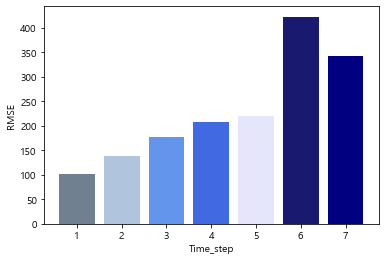

In [10]:
colors = ['slategrey', 'lightsteelblue', 'cornflowerblue', 'royalblue', 'lavender', 'midnightblue','navy']

plt.bar([1,2,3,4,5,6,7],rmse, color = colors)
plt.xlabel("Time_step")
plt.ylabel("RMSE")

Text(0, 0.5, 'R2')

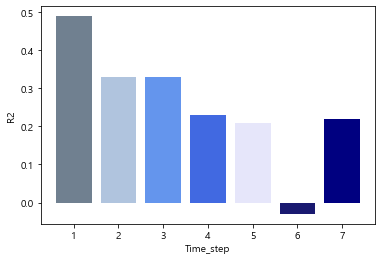

In [11]:
plt.bar([1,2,3,4,5,6,7],r2, color = colors)
plt.xlabel("Time_step")
plt.ylabel("R2")